### Import main functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [2]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [3]:
from plot_helpers import show_image, plot_clusters
from dataset_helpers import is_dmso, get_label
from dataset_helpers import low_clip, mean_clip, low_clip, minmax, max_normalise

In [4]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, BatchNormalization, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [5]:
def unishuffle(a, b, random_state=RS):
    assert len(a) == len(b)
    if random_state:
        np.random.seed(RS)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Read dataset

In [6]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')

In [7]:
y = npzfile['y']

In [8]:
y_dmso = np.array([get_label(i) for i in y])

In [9]:
X = npzfile['x']

## Image reconstruction

In [90]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val 
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(1920,3840)

def get_mask(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1),2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    return convert_to_binary(center[label])

In [30]:
def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.reshape((x.shape))

In [26]:
# work on reconstruction
new_img = np.ndarray(shape=(1920, 1920))

col = 0
y = 0
x = 0
for i in range(1000, 1100):
    new_img[x:x+192, y:y+192] = X[i]
    x = 192*col
    col += 1
    if col == 10:
        col = 0
        y += 192

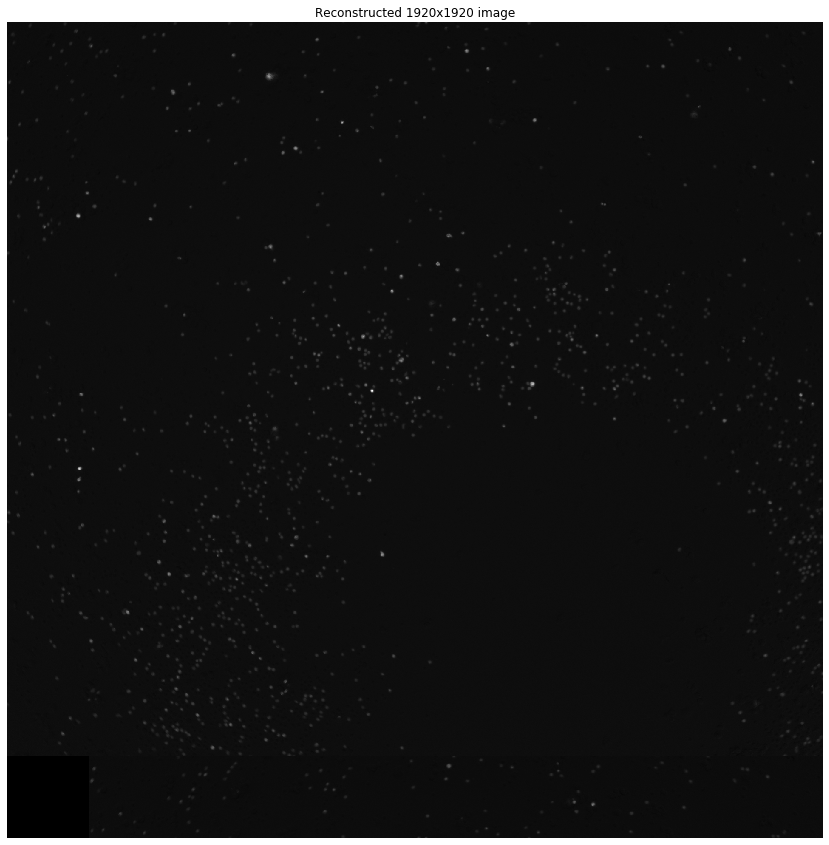

In [29]:
plt.figure(figsize=(15,15))
show_image(new_img, "Reconstructed 1920x1920 image")

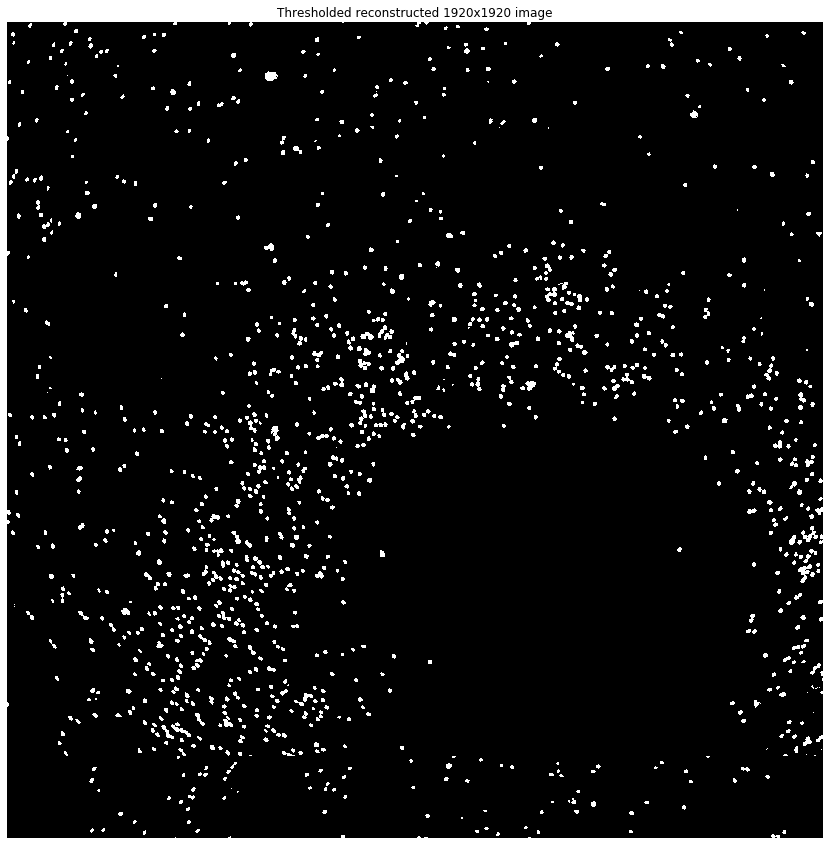

In [31]:
plt.figure(figsize=(15,15))
show_image(threshold(new_img), "Thresholded reconstructed 1920x1920 image")

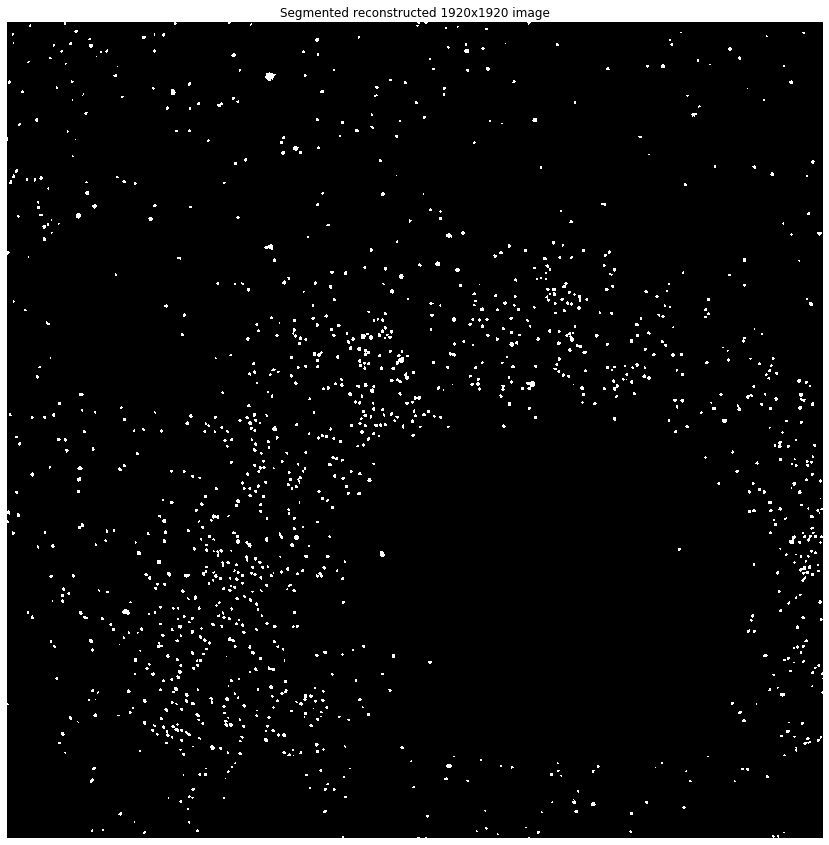

In [58]:
plt.figure(figsize=(15,15))
show_image(get_mask(new_img), "Segmented reconstructed 1920x1920 image")

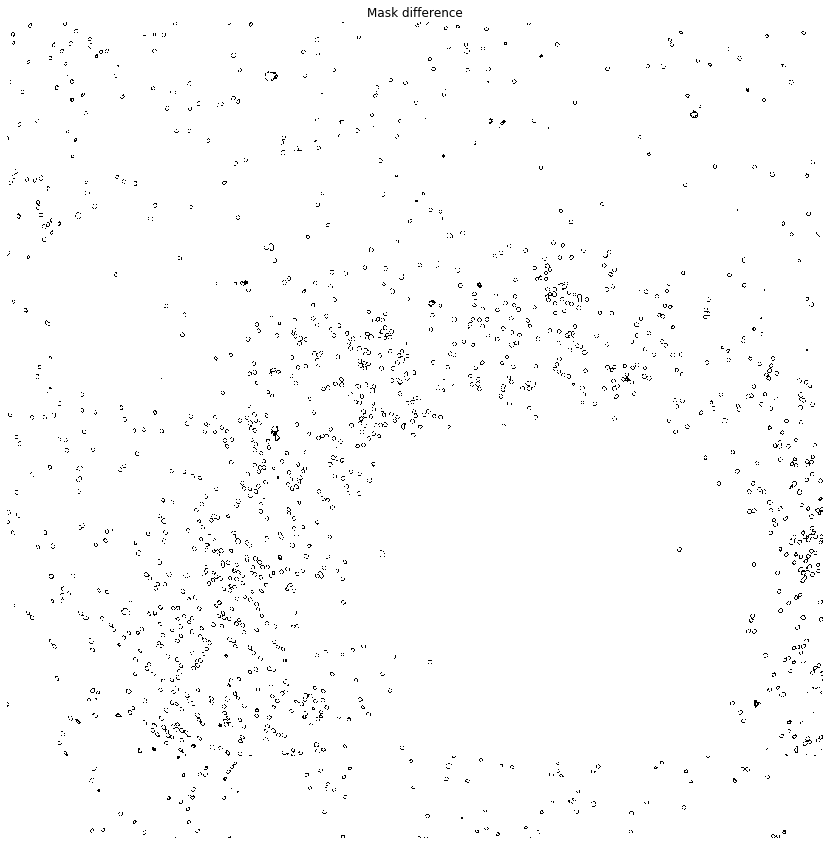

In [61]:
plt.figure(figsize=(15,15))
show_image(get_mask(new_img)-threshold(new_img), "Mask difference")

## Outliers and normalisation

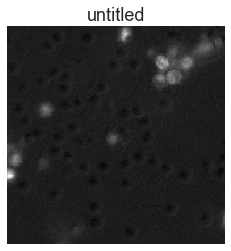

In [47]:
show_image(X[19586])

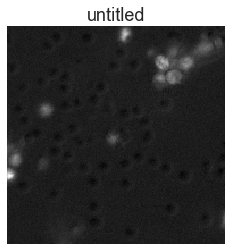

In [48]:
show_image(max_normalise(X[19586]))

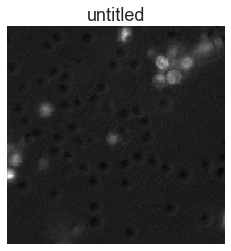

In [49]:
show_image(minmax(X[19586]))

In [53]:
max_normalise(X[19586]).min()

0.30980393

In [54]:
minmax(X[19586]).min()

0.0

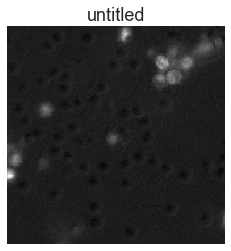

In [50]:
show_image(low_clip(X[19586]))

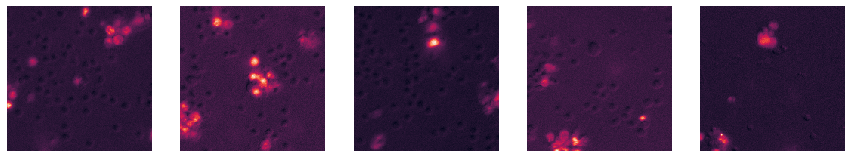

In [42]:
plot_range(X, rn=19585)

In [15]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

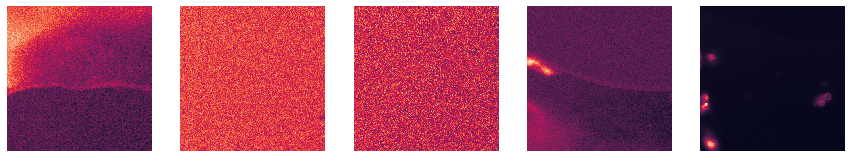

In [37]:
plot_range(X, rn=983)

In [38]:
y[983]

'/Volumes/TARDIS/CK19/CK19 - N - 5(fld 1 wv TexasRed - TexasRed).tif'

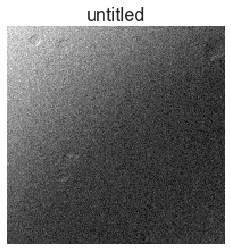

In [20]:
show_image(X[55]/np.max(X[55]))